# **Neural Network Optimization Techniques in PyTorch**

In this notebook, we explore various **optimization techniques** for a neural network built with **PyTorch**. We’ll focus on:
1. **SGD with Momentum** for the base training.  
2. **Learning Rate Scheduling** (e.g., `StepLR`) for adapting the learning rate over epochs.  
3. (Optionally) **Weight Decay (L2 Regularization)** to reduce overfitting.

The dataset chosen is **MNIST** (handwritten digit classification), but these techniques generalize to other datasets and deep learning tasks.


---

##📚 **Key Concepts for Optimization**

1. **Momentum**:  
   - Helps accelerate gradient descent in the correct direction, dampening oscillations.  

2. **Learning Rate Schedules**:  
   - Dynamically adjusts the learning rate to keep training stable and often achieve higher final accuracy.

3. **Weight Decay / L2 Regularization**:  
   - Penalizes large weights, helping to reduce overfitting by smoothing the loss landscape.

4. **Early Stopping**:  
   - Stop training when validation accuracy stops improving for some epochs, to prevent overfitting.

5. **Batch Normalization / Dropout** (not shown in detail here, but commonly used):  
   - **BatchNorm** normalizes layer inputs and can speed up training.  
   - **Dropout** randomly zeroes some activations to reduce overfitting.

---

## 🔗**Library Overview**

- **PyTorch** ([Documentation](https://pytorch.org/docs/stable/)):  
  - Core library for tensor computation (`torch`), neural network layers (`nn`), and optimization (`optim`).  
- **TorchVision** ([Documentation](https://pytorch.org/vision/stable/)):  
  - Common datasets (MNIST, CIFAR, ImageNet), transforms, etc.
- **Matplotlib** ([Documentation](https://matplotlib.org/)):  
  - Visualization of training curves, predictions, etc.

We also set seeds using **`torch.manual_seed(SEED)`**, **`np.random.seed(SEED)`**, and **`random.seed(SEED)`** to ensure experiment reproducibility where possible.


### **Imports and Setup**


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Ensure reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


**Explanation:**

1. **`torch`**, **`torch.nn`**, **`torch.optim`**, **`torch.nn.functional`**: Core PyTorch modules for building and training neural networks.
2. **`torch.utils.data`**: Data utilities like `DataLoader` and `random_split`.
3. **`torchvision.datasets`** and **`torchvision.transforms`**: For downloading and transforming image datasets (e.g., MNIST, CIFAR).
4. **`matplotlib.pyplot`**: Plotting utilities for visualizing losses, accuracies, etc.
5. **`numpy`** and **`random`**: Used for setting a seed to ensure reproducibility where possible.

We also set a manual seed (`SEED = 42`) for consistent results and choose **GPU** (`cuda`) if available.


### **Hyperparameters and Dataset**


In [2]:
# Hyperparameters
batch_size = 64
test_batch_size = 1000
learning_rate = 0.01
momentum = 0.9
num_epochs = 5
train_split = 0.9  # 90% for training, 10% for validation

# Dataset (e.g., MNIST for demonstration, but can be swapped out for another)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# Split training set into train and validation subsets
train_size = int(len(dataset) * train_split)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

print(f"Total training examples: {len(train_dataset)}")
print(f"Total validation examples: {len(val_dataset)}")
print(f"Total test examples: {len(test_dataset)}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 434kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.14MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.21MB/s]

Total training examples: 54000
Total validation examples: 6000
Total test examples: 10000


**Explanation:**

- **`batch_size` / `test_batch_size`**: Controls how many samples are processed at a time during training/testing.
- **`learning_rate`**, **`momentum`**, **`num_epochs`**: Key hyperparameters for model optimization.
- **`train_split`**: Splits the original training dataset into a training portion and a validation portion (often 80-90% train, 10-20% validation).
- **`transforms.Normalize`**: Normalizes the MNIST dataset with known mean and standard deviation.  
- **`random_split`**: Splits a dataset into two subsets (train and validation).  
- **DataLoader** usage:  
  - **`train_loader`**: Shuffled for training.  
  - **`val_loader`** / **`test_loader`**: Typically not shuffled or with separate shuffling logic for evaluation.


### **Defining a Simple Model**


In [3]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleModel().to(device)
print(model)


SimpleModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


**Explanation:**

A basic **fully connected** architecture for MNIST classification:

1. **`fc1`**: input size \(28×28 = 784\) → 128 hidden units  
2. **`fc2`**: 128 → 64  
3. **`fc3`**: 64 → 10 (digits from 0 to 9)  

We apply **ReLU** activations in the hidden layers. The **output** layer is just linear (we’ll apply cross-entropy for classification).


###**Defining Optimizer and Loss Function**

In [4]:
# Base optimizer (SGD) with momentum
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Loss function
criterion = nn.CrossEntropyLoss()


**Explanation:**

1. **`optim.SGD`**: Stochastic Gradient Descent with momentum.  
2. **`nn.CrossEntropyLoss()`**: Combines `LogSoftmax` and `NLLLoss`, suitable for multi-class classification.


### **Additional Optimization Techniques**


In [5]:
# Example of a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

# Example of weight decay (L2 regularization)
# You could instead define:
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-4)
#
# For demonstration, we'll apply scheduler and keep weight_decay commented out to highlight different techniques.


**Explanation:**

- **Learning Rate Scheduler** (`StepLR` in this example):  
  - Reduces the learning rate by `gamma` every `step_size` epochs (here, every epoch). This often helps with longer training runs to refine solutions.

- **Weight Decay** (L2 regularization):  
  - Helps prevent overfitting by penalizing large weights.  
  - Passed as **`weight_decay=1e-4`** (for example) to your optimizer’s constructor.

These can be combined or swapped out depending on the experiment and dataset size.


### **Training and Validation Functions**


In [6]:
def train_one_epoch(model, device, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, device, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * data.size(0)
            preds = outputs.argmax(dim=1)
            correct += preds.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    return val_loss, accuracy


**Explanation:**

- **`train_one_epoch`**:
  1. **`model.train()`**: Puts the model in training mode (enabling dropout, etc. if used).  
  2. Zeroes out gradients, does a forward pass, computes loss, backpropagates, and updates weights.  
  3. Accumulates total loss for the epoch and returns the **average** loss per example.

- **`validate`**:
  1. **`model.eval()`**: Disables training-specific layers/behaviors.  
  2. Tracks **running_loss** and correct predictions.  
  3. Returns **average validation loss** and **validation accuracy** in percentage.


### **Main Training Loop**


In [7]:
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train for one epoch
    avg_train_loss = train_one_epoch(model, device, train_loader, optimizer, criterion)
    train_losses.append(avg_train_loss)

    # Validate on the validation set
    avg_val_loss, val_accuracy = validate(model, device, val_loader, criterion)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Step the scheduler (if used)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")


Epoch [1/5], Train Loss: 0.3352, Val Loss: 0.1651, Val Accuracy: 94.77%
Epoch [2/5], Train Loss: 0.1185, Val Loss: 0.1197, Val Accuracy: 96.40%
Epoch [3/5], Train Loss: 0.0808, Val Loss: 0.1074, Val Accuracy: 96.70%
Epoch [4/5], Train Loss: 0.0617, Val Loss: 0.0979, Val Accuracy: 96.92%
Epoch [5/5], Train Loss: 0.0511, Val Loss: 0.0934, Val Accuracy: 97.25%


**Explanation:**

- Runs **`train_one_epoch`** then **`validate`** each epoch.
- Records:
  - **`train_losses`**: The average training loss for each epoch.
  - **`val_losses`** and **`val_accuracies`**: Validation metrics.
- **`scheduler.step()`** after each epoch to adjust the learning rate if a scheduler is defined.
- Prints a summary of training/validation performance each epoch.


### **Visualizing Training Curves**


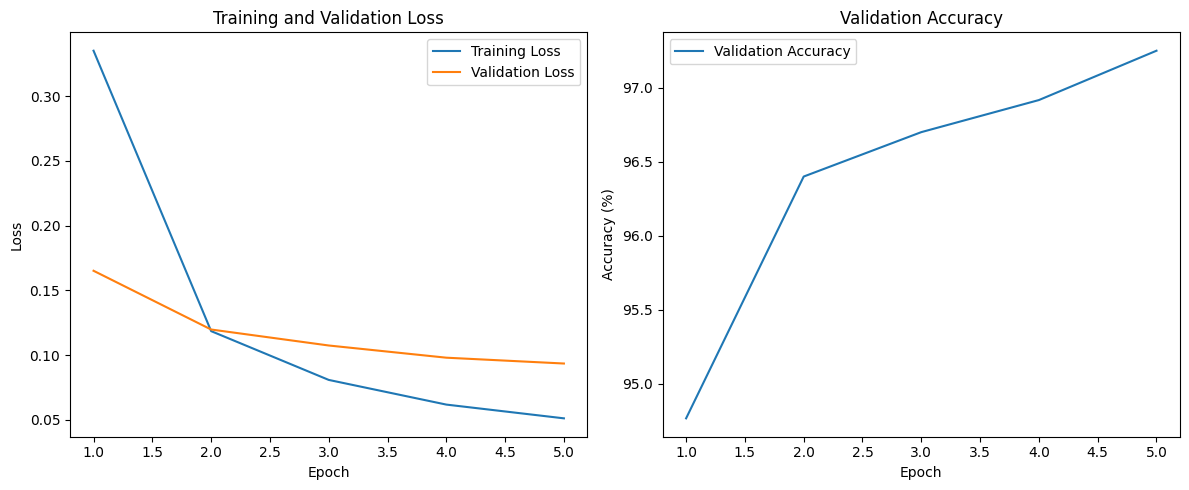

In [8]:
epochs_range = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


**Explanation:**

- Plots:
  1. **Training vs. Validation Loss** to see if the model might be overfitting.  
  2. **Validation Accuracy** to measure how performance improves over epochs.

These plots help diagnose problems like underfitting, overfitting, or suboptimal hyperparameters.


###**Testing on the Test Set**

In [9]:
test_loss, test_accuracy = validate(model, device, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.0769, Test Accuracy: 97.56%


**Explanation:**

- Uses the **`validate`** function on the **`test_loader`** (data unseen during training or validation).  
- Prints the final **Test Loss** and **Test Accuracy** as key performance metrics.


### **Model Saving and Loading**


In [10]:
model_path = "optimized_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}.")

# Example of loading:
# loaded_model = SimpleModel().to(device)
# loaded_model.load_state_dict(torch.load(model_path))
# loaded_model.eval()


Model weights saved to optimized_model.pth.


**Explanation:**

- **`torch.save(model.state_dict(), '...')`**: Saves only the model’s learned parameters (weights/biases).  
- **`model.load_state_dict(torch.load('...'))`**: Restores weights to a compatible model instance.


### **Visualizing Sample Predictions**


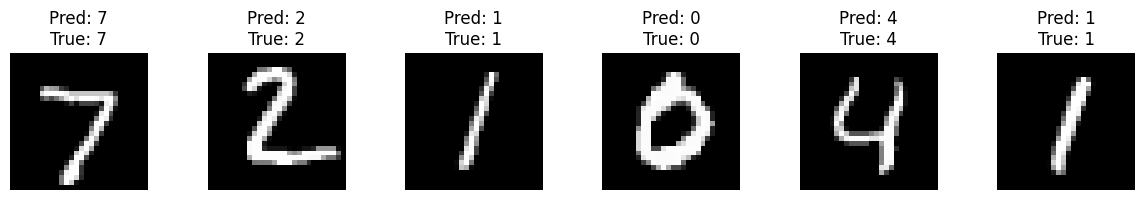

In [11]:
def visualize_predictions(model, loader, device, num_images=6):
    model.eval()
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1)

    # Plot images and predictions
    fig, axes = plt.subplots(1, num_images, figsize=(12,2))
    for i in range(num_images):
        axes[i].imshow(images[i].cpu().view(28, 28), cmap='gray')
        axes[i].set_title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a batch of predictions
visualize_predictions(model, test_loader, device, num_images=6)


**Explanation:**

- **`visualize_predictions`**:
  - Fetches a batch of data from a specified loader (test or validation).  
  - Runs a forward pass to get predictions.  
  - Plots a few images in a row, showing predicted vs. true labels.

## 📚**Additional Reading & References**

- **PyTorch Tutorials**: [https://pytorch.org/tutorials/](https://pytorch.org/tutorials/)  
  Step-by-step guides for advanced features, such as other schedulers, advanced optimizers, etc.

- **Stanford CS231n**: [cs231n.github.io](http://cs231n.github.io/)  
  Great resource for understanding backprop, optimization, CNNs, etc.

- **Deep Learning Book** ([Goodfellow et al.](https://www.deeplearningbook.org/)):  
  Chapters on optimization and regularization are highly relevant.

- **Kaggle Notebooks** for optimization techniques:  
  - **Intuitive Explanation of SGD, Adam, and RMSProp**  
  This notebook provides an intuitive understanding of three popular optimization algorithms: Stochastic Gradient Descent (SGD), Adam, and RMSProp.  
  [View on Kaggle](https://www.kaggle.com/code/harpdeci/intuitive-explanation-of-sgd-adam-and-rmsprop)

  - **SGD/ADAM Optimizer Benchmark with Transfer Learning**  
    This notebook benchmarks the performance of SGD and Adam optimizers using transfer learning on the Flowers dataset from TensorFlow.  
    [View on Kaggle](https://www.kaggle.com/code/hrideshkohli/sgd-adam-optimizer-benchmark-with-transferlearning)

  - **How Does Your Cosine Annealing with Warm-up Work?**  
    This notebook demonstrates the implementation and effects of cosine annealing with warm-up in learning rate scheduling.  
    [View on Kaggle](https://www.kaggle.com/code/bibhabasumohapatra/how-does-your-cosine-annealing-with-warm-up-works)

  - **Guide to PyTorch Learning Rate Scheduling**  
    This notebook offers a comprehensive guide to implementing various learning rate scheduling techniques in PyTorch, including cosine annealing.  
    [View on Kaggle](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling)

These resources should provide valuable insights into optimization techniques and learning rate scheduling in deep learning.
